# Convolving phase reconstructions to find specimens

Questions to answer: 
* What kinds of kernels can be used to increase the contrast on specimens in the field?
* What are the fastest/most convenient implementations of convolution for this problem?
* What is the phase "PSF" like?

In [1]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import matplotlib.pyplot as plt
import numpy as np

## Import dev version of shampoo
import os, sys
sys.path.insert(0, os.getenv('SHAMPOO_DIR'))
import shampoo

Reconstruct a hologram at a distance where one cell is in focus. 

In [2]:
from shampoo import Hologram

centroid = (341+0.5, 597+0.5)
margin = 100
propagation_distance = 0.024040404040404 # m

hologram_path = ('/Users/bmmorris/SHAMU/2015.05.15_17-58_'
                 'Vibrio_on_slide_+_dye_r/00030_holo.tif')

h = Hologram.from_tif(hologram_path, crop_fraction=2**-1)
wave = h.reconstruct(propagation_distance)

Lay down a centroid on the cell that is in focus in this frame for aperture photometry.

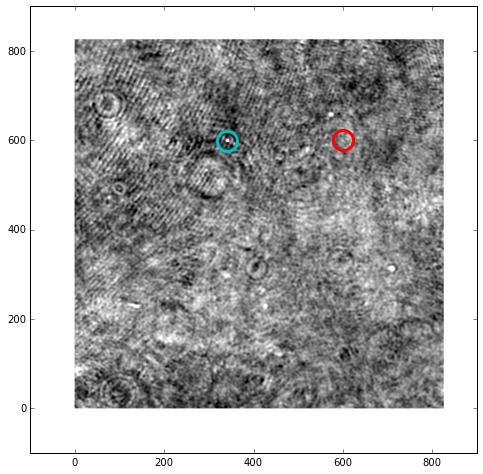

In [3]:
def plot_phase(phase, ax=None):
    if ax is None:
        ax = plt.gca()
    plt.imshow(phase, cmap=plt.cm.binary_r,
               vmin=np.percentile(phase, 0.1),
               vmax=np.percentile(phase, 99.9), origin='lower')

cropped_phase = wave.phase[margin:-margin, margin:-margin]
plt.figure(figsize=(8, 8))
plot_phase(cropped_phase)
plt.plot(*centroid, 'co', ms=20, mew=3, fillstyle='none')

bg_centroid = (600, 600)
plt.plot(*bg_centroid, 'ro', ms=20, mew=3, fillstyle='none')

Roughly measure the PSF to see where the flux tops out using circular apertures

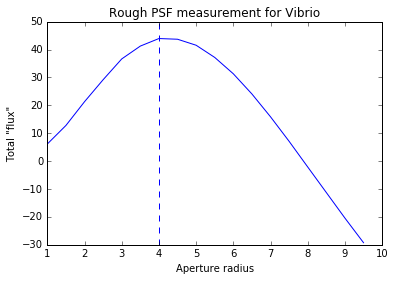

In [4]:
from astropy.convolution import MexicanHat2DKernel, convolve, convolve_fft

from photutils import CircularAperture, aperture_photometry
radii = np.arange(1, 10, 0.5)
fluxes = []
for radius in radii:
    aper = CircularAperture([centroid, bg_centroid], radius)
    f_target, f_bg = aperture_photometry(cropped_phase, aper)['aperture_sum'].data
    signal_to_noise = f_target#/f_bg
    fluxes.append(signal_to_noise)

plt.plot(radii, fluxes)
best_aperture_radius = radii[np.argmax(fluxes)]
plt.axvline(best_aperture_radius, ls='--')
ax = plt.gca()
ax.set(xlabel='Aperture radius', ylabel='Total "flux"', 
       title='Rough PSF measurement for Vibrio')

Try convolving the `MexicanHat2DKernel` with the phase reconstruction, find where the flux in the aperture peaks. 

In [5]:
kernel_radii = np.arange(1, 8, 0.5)
f_kernel = []
for k_rad in kernel_radii:
    convolved_img = convolve_fft(cropped_phase, MexicanHat2DKernel(k_rad))

    f = aperture_photometry(convolved_img,
                            CircularAperture(centroid, 
                                             2*best_aperture_radius))['aperture_sum'].data[0]
    f_kernel.append(f)

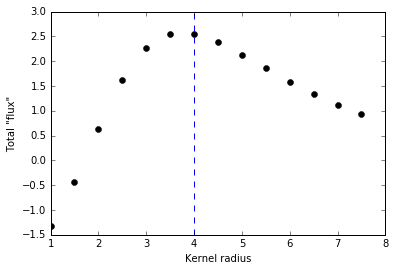

In [6]:
plt.plot(kernel_radii, f_kernel, 'ok')

best_kernel_radius = kernel_radii[np.argmax(f_kernel)]
plt.axvline(best_kernel_radius, ls='--')

plt.xlabel('Kernel radius')
plt.ylabel('Total "flux"')

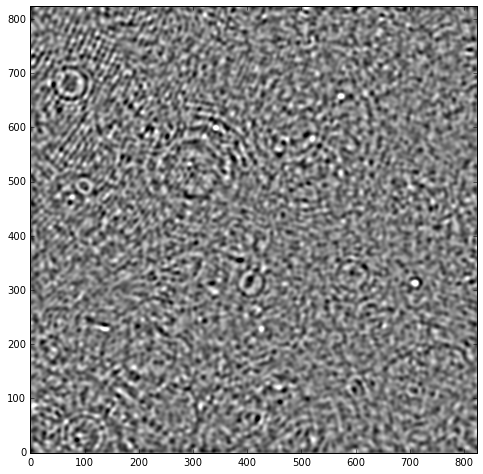

In [7]:
best_convolved_phase = convolve_fft(cropped_phase, 
                                MexicanHat2DKernel(best_kernel_radius))
plt.figure(figsize=(8, 8))
plot_phase(best_convolved_phase)

## Speed

The fastest 2D convolution method seems to be `astropy.convolution.convolve_fft` when used with `pyfftw`

In [8]:
%%timeit
convolve_fft(cropped_phase, MexicanHat2DKernel(best_kernel_radius))

1 loops, best of 3: 320 ms per loop


In [10]:
%%timeit
convolve(cropped_phase, MexicanHat2DKernel(best_kernel_radius))

1 loops, best of 3: 2 s per loop


In [12]:
from pyfftw.interfaces.scipy_fftpack import fft2, ifft2

In [13]:
%%timeit
convolve_fft(cropped_phase, MexicanHat2DKernel(best_kernel_radius), 
             fftn=fft2, ifftn=ifft2)

10 loops, best of 3: 148 ms per loop


In [14]:
from scipy.signal import convolve2d

In [15]:
%%timeit
convolve2d(cropped_phase, MexicanHat2DKernel(best_kernel_radius).array)

1 loops, best of 3: 2.05 s per loop


## Blob finding

On convolved image:

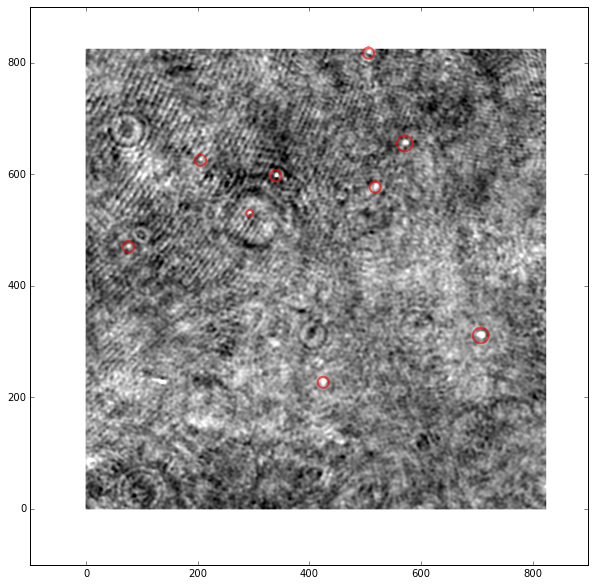

In [151]:
from skimage.feature import blob_doh
blobs = blob_doh(cropped_phase, min_sigma=1, max_sigma=20, threshold=0.025)

plt.figure(figsize=(10, 10))
plot_phase(cropped_phase)

theta = np.linspace(0, 2*np.pi, 30)
def circle(x, y, radius):
    radius *= 2
    return radius*np.sin(theta) + y, radius*np.cos(theta) + x


for blob in blobs:
    plt.plot(*circle(*blob), color='r', lw='2', alpha=0.6)

plt.show()

On raw image

In [135]:
print(type(best_convolved_phase))

<class 'numpy.ndarray'>


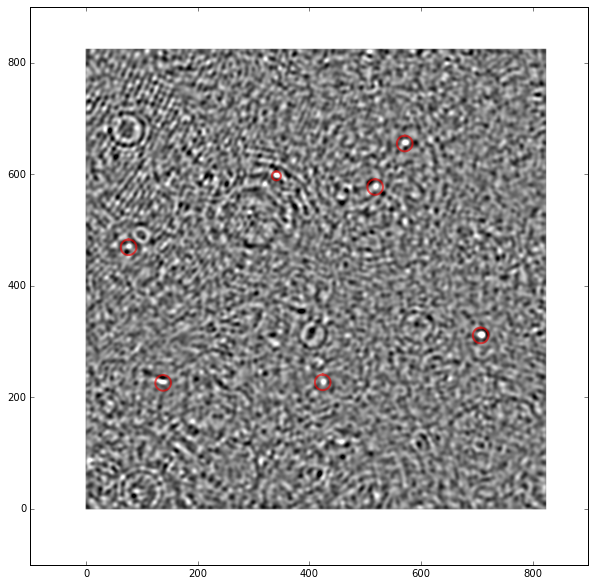

In [146]:
from skimage.feature import blob_doh
best_convolved_phase = best_convolved_phase.copy(order='C')
blobs = blob_doh(best_convolved_phase, min_sigma=1, max_sigma=30, threshold=0.00003)

plt.figure(figsize=(10, 10))
plot_phase(best_convolved_phase)

theta = np.linspace(0, 2*np.pi, 30)
def circle(x, y, radius):
    radius *= 2
    return radius*np.sin(theta) + y, radius*np.cos(theta) + x

for blob in blobs:
    plt.plot(*circle(*blob), color='r', lw='2', alpha=0.6)

plt.show()

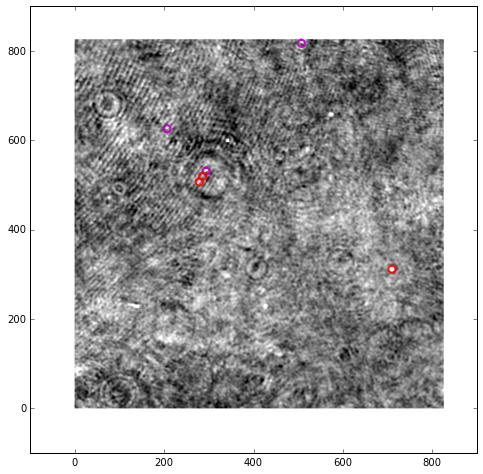

In [132]:
from photutils import datasets, daofind, irafstarfind
from astropy.stats import sigma_clipped_stats

# mean, median, std = sigma_clipped_stats(best_convolved_phase, 
mean, median, std = sigma_clipped_stats(cropped_phase, sigma=3.0, iters=1)
circular_sources = daofind(cropped_phase - median, fwhm=3.5, 
                           threshold=1.*std, exclude_border=True)   
elliptical_sources = daofind(cropped_phase - median, fwhm=3.5, ratio=0.5, 
                             threshold=1.*std, exclude_border=True)

plt.figure(figsize=(8, 8))
plot_phase(cropped_phase)

for c, e in zip(circular_sources, elliptical_sources):
    blob_c = (c['ycentroid'], c['xcentroid'], 4)
    blob_e = (e['ycentroid'], e['xcentroid'], 4)
    plt.plot(*circle(*blob_c), color='r', lw='2', alpha=0.9)
    plt.plot(*circle(*blob_e), color='m', lw='2', alpha=0.9)